# Checking convergence of posteriors using the `pints.diagnostics` module

Sampling from posteriors using `pints` is easy, but how do you know when you ran enough iterations such that the samples estimate the posterior reasonably well? The short answer to this is that you almost never know whether your samples approximate the true posterior, unless you know the true posterior or rerun the inference for a generative model many times, see REF. However, you can determine when running any more iterations will not improve your approximation of the posterior.

The main reason why it is hard to know if a sampled posterior approximates the true posterior is that some regions in parameter space may systematically be badly explored, and as parameter space can be vast you may never know. However you can check whether the MCMC routine consistently infers the same posterior distribution, which can be done with the convergence metric $\hat{R}$ which is implemented in pints as `pints.diagnostics.rhat`.

## Toy example: 2 dimensional Gaussian distribution

Let's consider as a toy example the standard 2 dimensional Gaussian distribution
\begin{equation}
    X \sim \mathcal{N}(\vec{0}, \Sigma),
\end{equation}
where $\vec{0} = (0, 0)^T$ and $\Sigma = \text{diag}(1, 1)$. The Gaussian distribution will serve as a toy posterior distribution and we will use an adaptive covariance MCMC sampler to infer it.

### Infer posterior

To infer the posterior we will run 5 chains from initial positions that are randomly drawn from a 2 dimensional Gaussian distribution with covariance matrix $\Sigma = \text{diag}(10, 10)$. This emulates the common workflow of sampling from an overdispersed prior. We will run all chains 10000 iterations and then investigate the convergence of our sample routine.

In [1]:
import pints
import pints.toy

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))

# Set up hyperparameters
n_chains = 5
initial_parameters = log_prior.sample(n=n_chains)
n_iterations = 10000
method = pints.HaarioBardenetACMC

# Set up problem
sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_log_to_screen(False)

# Sample
chains = sampler.run()

### Visualise marginal posteriors and traces

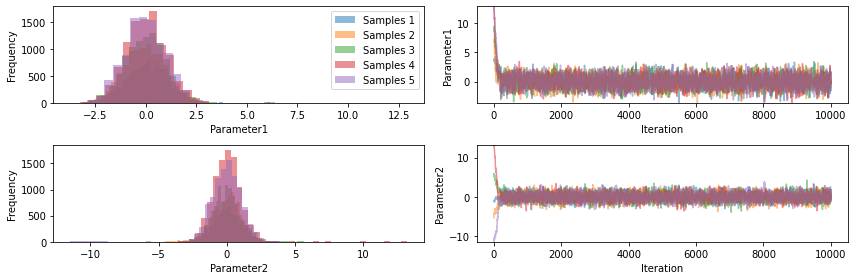

In [2]:
import matplotlib.pyplot as plt
import pints.plot

# Plot traces
fig = pints.plot.trace(chains)
plt.show()

We can observe some initial differences between the chains up to iteration $\approx 500$ which is commonly known as the warm up phase. In this warm up phase the chains sample very different values because they start from overdispersed initial points in parameter space. So they simply need some time to move away from the low probability areas in parameter space and find the more interesing regions. These initial samples are not representative of the underlying posterior and rather reflect the fact that the MCMC sampler can only explore a finite region of the parameter space at each iteration. It is therefore customary to exclude the warm up phase.

### Exclude warm up phase

To be savely out of the warm up phase we will exclude the first 1000 iterations.

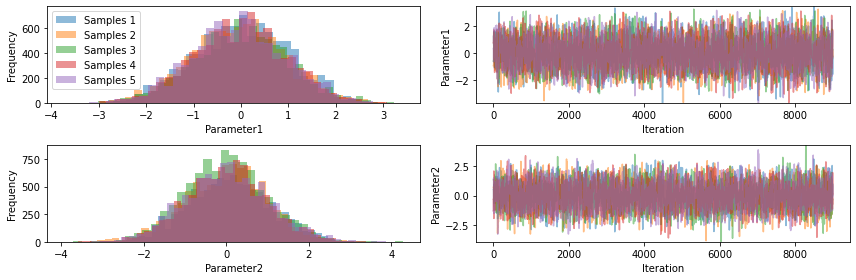

In [3]:
warmup = 1000

# Plot traces
fig = pints.plot.trace(chains[:, warmup:])
plt.show()

### Determine iteration at which marginal posteriors converge

To determine the degree of convergence we can compute the $\hat{R}$ metric up to different interation numbers.

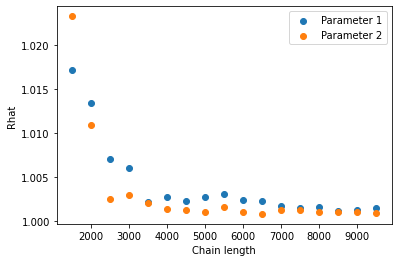

In [4]:
import numpy as np

import pints.diagnostics

# Define chain lengths for Rhat evaluation
step_size = 500
chain_lengths = np.arange(
    start=warmup+step_size, stop=n_iterations, step=step_size)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=(n_lengths, n_parameters))
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat
    rhats[length_id] = pints.diagnostics.rhat(cleaned_chains)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.legend()
plt.show()

A widely applied criterion is to argue that the marginal distributions have reasonably well converged for scores of $\hat{R} < 1.01$. However, investigating the $\hat{R}$ score alone does not suffice as it's estimation error depends on the effective number of samples.

### Effective sample size (ESS) and correlation between samples

The effective sample size is the number of samples in a chain corrected by the correlation between the samples. In general, samples from one iteration to the next may be correlated because of the local exploration of the parameter space by the sampler. The autocorrelation can be computed for all chains with `pints.diagnostics.autocorrelation` or visualised for each chain separately with `pints.plot.autocorrelation`.

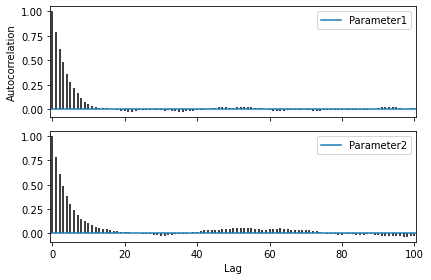

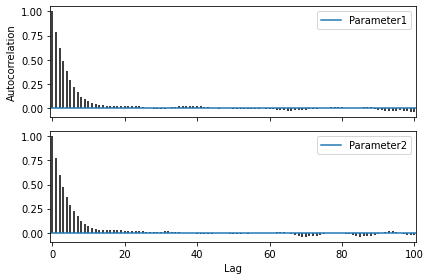

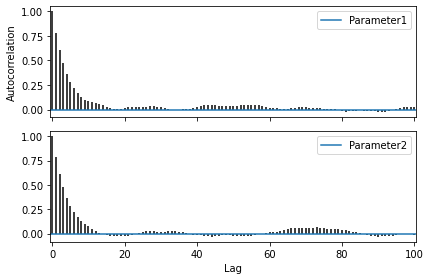

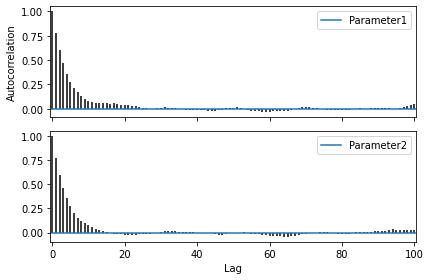

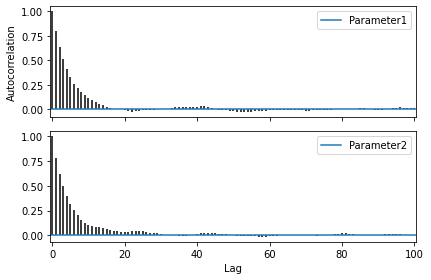

In [9]:
# Plot autocorrelation
for chain in chains:
    fig = pints.plot.autocorrelation(chain[warmup:])
    plt.show()

Correcting for the correlations between samples at different lags we can estimate the effective sample size across chains with `pints.diagnostics.effective_sample_size`.

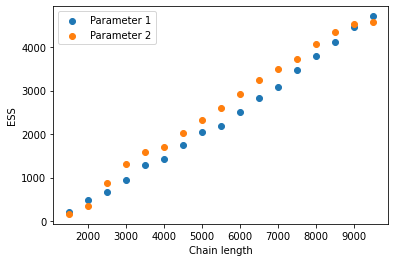

In [11]:
# Compute ess
n_parameters = 2
n_lengths = len(chain_lengths)
ess = np.empty(shape=(n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute ess
    ess[length_id] = pints.diagnostics.effective_sample_size(cleaned_chains)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('ESS')
plt.legend()
plt.show()

The commonly accepted lower limit of effective sample size for the estimation of $\hat{R}$ is 500 effective samples. As a result, 3000 iterations seems to be a feasible length for the chains.

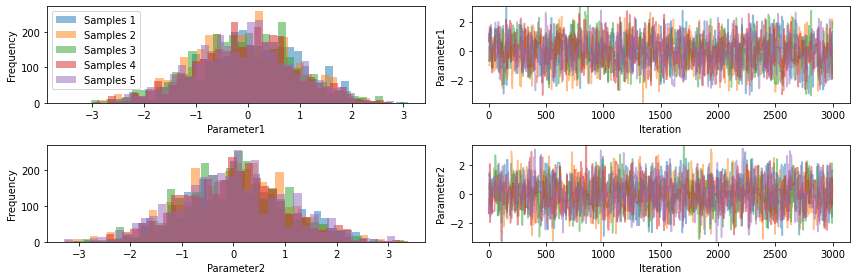

In [12]:
# Plot traces
fig = pints.plot.trace(chains[:, warmup:4000])
plt.show()